<a href="https://colab.research.google.com/github/Raj-1566/AI-Powered-Identity-Verification-and-Fraud-Detection-for-KYC-Compliance/blob/main/Modelling_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Create a Graph from Your KYC Data

We’ll use your cleaned DataFrame (df) and create a graph where:

Each node = one person (a row in your DataFrame)

Each edge = similarity or relationship (e.g., same address, same document type, high text similarity)

We’ll build this using NetworkX first.

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd # Import pandas

# Load the data into a pandas DataFrame , output of previous code file (modelling part1)
df = pd.read_csv('/content/sample_data/Output_of_modelling_part1.csv')

# Step 1️⃣ : Create Graph
G = nx.Graph()

# Add nodes for each record
for idx, row in df.iterrows():
    G.add_node(idx,
                name=row['Name_clean'],
                gender=row['Gender_clean'],
                doc_type=row['Document_type_clean'],
                fraud_score=row['Fraud_Risk_Score'])

# Add edges based on similarity or shared features
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        # If they share same address or document number
        if df.loc[i, 'Address_clean'] == df.loc[j, 'Address_clean'] or df.loc[i, 'Document_Number'] == df.loc[j, 'Document_Number']:
            G.add_edge(i, j, relation='shared_info')

Now you have a KYC Relationship Graph.

#Step 2: Convert Graph to GNN-ready format

GNNs need numeric tensors, not raw text.
We’ll use torch_geometric (PyTorch Geometric) to represent the graph.

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.2 MB/s eta 0:00:00


In [ ]:
from torch_geometric.utils import from_networkx
import torch

# Convert NetworkX to PyTorch Geometric Data object
data = from_networkx(G)

# Create node features
data.x = torch.tensor(df[['Fraud_Risk_Score']].values, dtype=torch.float)

# Optional: Labels if you have them (e.g., 0=Not Fraud, 1=Fraud)
data.y = torch.tensor((df['Fraud_Risk_Level'] == 'High').astype(int).values)


#Step 3: Define a Simple GNN Model

We’ll start with a 2-layer Graph Convolutional Network (GCN).

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear

class FraudGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FraudGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.linear = Linear(output_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = self.linear(x)
        return torch.sigmoid(x)


#Step 4: Train and Validate the GNN

In [ ]:
model = FraudGNN(input_dim=1, hidden_dim=16, output_dim=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.view(-1), data.y.float())
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 0.8825
Epoch 10 | Loss: 0.6299
Epoch 20 | Loss: 0.3161
Epoch 30 | Loss: 0.1549
Epoch 40 | Loss: 0.1438


#Step 5: Generate Predictions (Fraud Probability)

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(data).view(-1).numpy()

df['GNN_Fraud_Probability'] = predictions


In [ ]:
df.head()

,Name,Gender,DOB,Document_Type,Document_Number,Address,Name_clean,Address_clean,Gender_clean,Document_type_clean,Document_format,Combined_Data,Duplicate_Group_ID,Fraud_Risk_Score,Fraud_Risk_Level,GNN_Fraud_Probability
0,Mohanlal Sinha,Other,04-08-1975,Passport,K3935412,"866, Borah Street, Hubli–Dharwad-639425",mohanlal sinha,866 borah street hublidharwad639425,other,passport,True,mohanlal sinha other 04-08-1975 passport K3935...,-1,0.0,Low,0.020695
1,Emir Gola,Male,12-03-1993,PAN,CCXHG1852M,"H.No. 19, De Zila, North Dumdum 451695",emir gola,hno 19 de zila north dumdum 451695,male,pan,True,emir gola male 12-03-1993 pan CCXHG1852M hno 1...,-1,0.0,Low,0.020695
2,Krish D’Alia,Female,11-12-1974,PAN,QDBHD4336T,"H.No. 993, Sur Street, Uluberia 045795",krish dalia,hno 993 sur street uluberia 045795,female,pan,True,krish dalia female 11-12-1974 pan QDBHD4336T h...,-1,0.0,Low,0.020695
3,Sana Khatri,Other,NaN,Passport,V9387476,"H.No. 00, Vasa Nagar, Bhalswa Jahangir Pur-818798",sana khatri,hno 00 vasa nagar bhalswa jahangir pur818798,other,passport,True,sana khatri other missing passport V9387476 hn...,-1,0.3,Medium,0.009372
4,Raghav Mahajan,Female,28-12-1977,Aadhaar,8961 3216 2241,"75/993, Sahota Road, Rampur-792972",raghav mahajan,75993 sahota road rampur792972,female,aadhaar,False,raghav mahajan female 28-12-1977 aadhaar 8961 ...,-1,0.4,Medium,0.007186


/tmp/ipython-input-3273420699.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Fraud_Risk_Level', data=df, order=order, palette=palette)


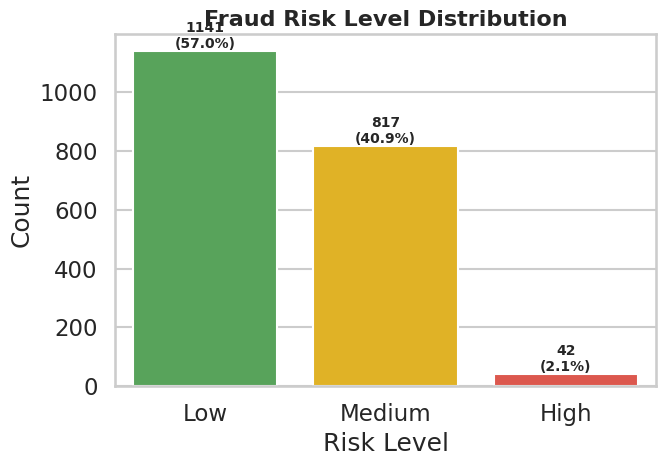

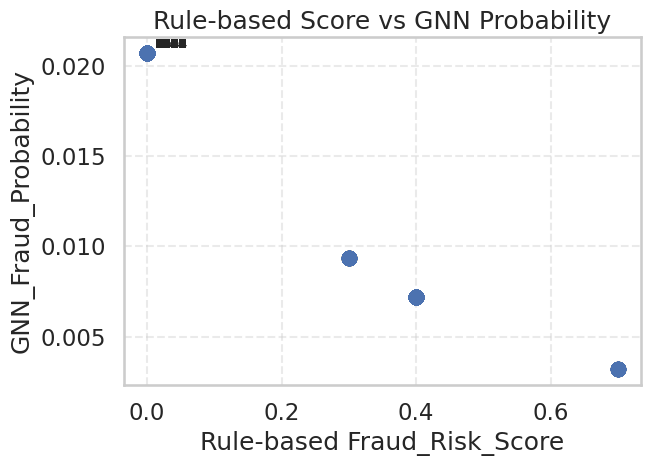

/tmp/ipython-input-3273420699.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')
/usr/local/lib/python3.12/dist-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


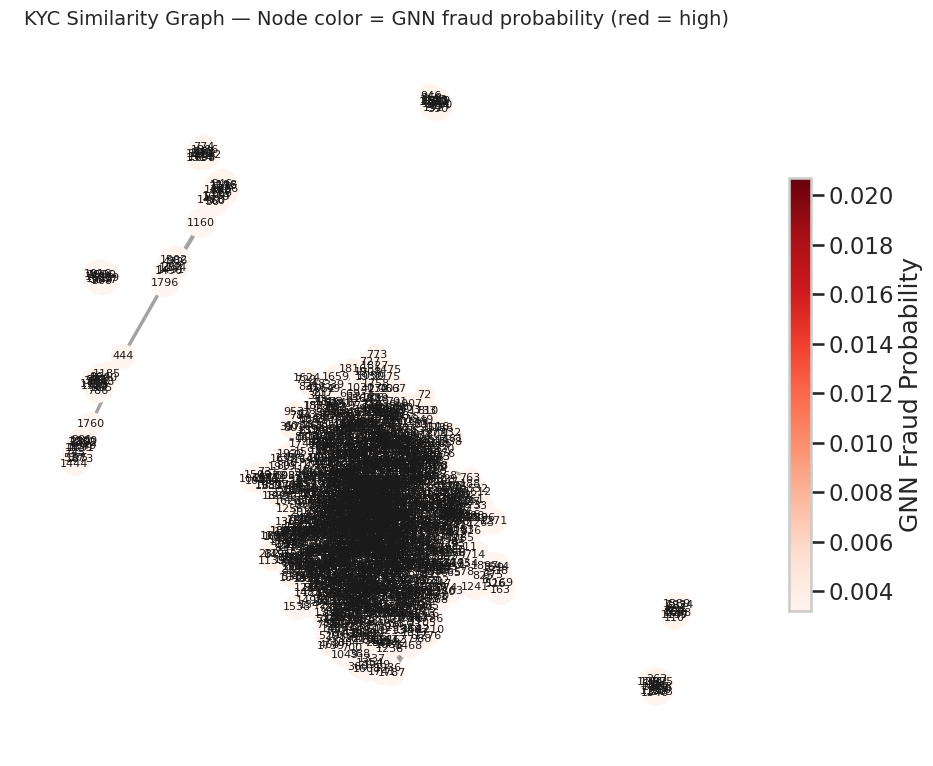


Top suspicious nodes (by GNN probability) with neighbor evidence:



,index,name,gnn_prob,rule_score,risk_level,address,top_neighbors
0,0,Mohanlal Sinha,0.020695,0.0,Low,"866, Borah Street, Hubli–Dharwad-639425","[{'index': 829, 'name': 'Heer Dua', 'gnn_prob': 0.020694918930530548, 'rule_score': 0.0, 'risk_level': 'Low'}, {'index': 1086, 'name': 'Azad Sarin', 'gnn_prob': 0.020694918930530548, 'rule_score': 0.0, 'risk_level': 'Low'}, {'index': 495, 'name': 'Lavanya Talwar', 'gnn_prob': 0.007185629103332758, 'rule_score': 0.4, 'risk_level': 'Medium'}, {'index': 312, 'name': 'Neysa Biswas', 'gnn_prob': 0...."
1,1983,Oorja Dalal,0.020695,0.0,Low,"H.No. 811, Krish Road, Chinsurah 137758","[{'index': 258, 'name': 'Divit Konda', 'gnn_prob': 0.020694918930530548, 'rule_score': 0.0, 'risk_level': 'Low'}, {'index': 1228, 'name': 'Renee Swamy', 'gnn_prob': 0.020694918930530548, 'rule_score': 0.0, 'risk_level': 'Low'}, {'index': 962, 'name': 'Mannat Sharaf', 'gnn_prob': 0.020694918930530548, 'rule_score': 0.0, 'risk_level': 'Low'}, {'index': 956, 'name': 'Ira Barad', 'gnn_prob': 0.020..."
2,1,Emir Gola,0.020695,0.0,Low,"H.No. 19, De Zila, North Dumdum 451695","[{'index': 172, 'name': 'Elakshi Buch', 'gnn_prob': 0.007185629103332758, 'rule_score': 0.4, 'risk_level': 'Medium'}, {'index': 442, 'name': 'Seher Kapoor', 'gnn_prob': 0.020694918930530548, 'rule_score': 0.0, 'risk_level': 'Low'}, {'index': 760, 'name': 'Alisha Cherian', 'gnn_prob': 0.020694918930530548, 'rule_score': 0.0, 'risk_level': 'Low'}, {'index': 834, 'name': 'Pranay Zachariah', 'gnn_..."
3,1201,Manjari Chaudry,0.020695,0.0,Low,"79, Gala Marg, North Dumdum-697093","[{'index': 259, 'name': 'Anahi Tara', 'gnn_prob': 0.020694918930530548, 'rule_score': 0.0, 'risk_level': 'Low'}, {'index': 598, 'name': 'Suhana Sahota', 'gnn_prob': 0.020694918930530548, 'rule_score': 0.0, 'risk_level': 'Low'}, {'index': 722, 'name': 'Tejas Vyas', 'gnn_prob': 0.007185629103332758, 'rule_score': 0.4, 'risk_level': 'Medium'}, {'index': 991, 'name': 'Adira Dayal', 'gnn_prob': 0.0..."
4,1203,Hrishita Jaggi,0.020695,0.0,Low,"66, Deol Road, Aligarh-292339","[{'index': 59, 'name': 'Jivika Tara', 'gnn_prob': 0.020694918930530548, 'rule_score': 0.0, 'risk_level': 'Low'}, {'index': 109, 'name': 'Lavanya Kanda', 'gnn_prob': 0.007185629103332758, 'rule_score': 0.4, 'risk_level': 'Medium'}, {'index': 191, 'name': 'Arhaan Saraf', 'gnn_prob': 0.020694918930530548, 'rule_score': 0.0, 'risk_level': 'Low'}, {'index': 288, 'name': 'Rati Subramanian', 'gnn_pro..."


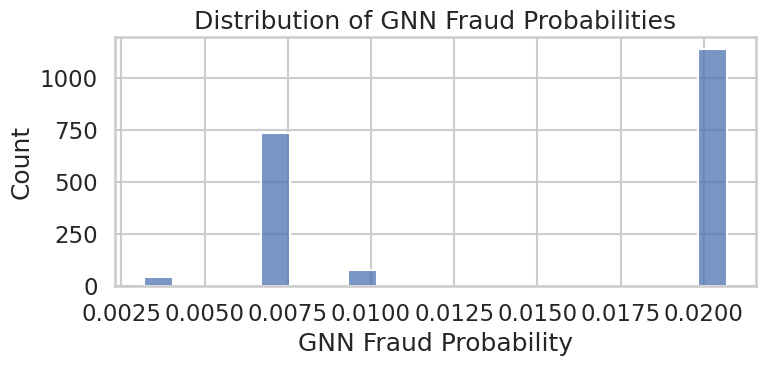

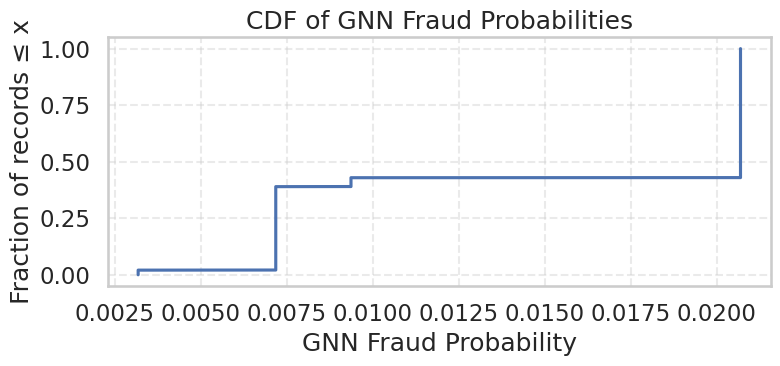

/tmp/ipython-input-3273420699.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Fraud_Risk_Level', data=df, order=order, palette=palette)



Saved one sample chart to ./kyc_viz_outputs/fraud_risk_distribution.png
Visualization complete. Inspect the graph, the top suspicious table, and the comparison plots above.


In [ ]:
# Visualize KYC dataset, graph, and model outputs
# Paste and run after your df exists in the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

sns.set(style="whitegrid", context="talk")

# ---------- 0. Safety / prepare df ----------
# If df is not present, try to load from CSV (uncomment and change path)
# df = pd.read_csv('/content/kyc_final_processed.csv')

# Ensure required columns exist and are well-typed
df = df.copy()
for col in ['Combined_Data', 'Fraud_Risk_Level', 'Fraud_Risk_Score', 'GNN_Fraud_Probability']:
    if col not in df.columns:
        raise ValueError(f"DataFrame missing required column: {col}")

df['Combined_Data'] = df['Combined_Data'].fillna('').astype(str)
df['Fraud_Risk_Level'] = df['Fraud_Risk_Level'].fillna('Unknown').astype(str)
df['GNN_Fraud_Probability'] = pd.to_numeric(df['GNN_Fraud_Probability'].fillna(0.0))
df['Fraud_Risk_Score'] = pd.to_numeric(df['Fraud_Risk_Score'].fillna(0.0))

# ---------- 1. Risk Distribution bar chart (colored + percentages) ----------
plt.figure(figsize=(7,5))
order = ['Low', 'Medium', 'High']
palette = {'Low':'#4CAF50','Medium':'#FFC107','High':'#F44336'}
ax = sns.countplot(x='Fraud_Risk_Level', data=df, order=order, palette=palette)
plt.title("Fraud Risk Level Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Risk Level")
plt.ylabel("Count")

# annotate percentages above bars
total = len(df)
for p in ax.patches:
    height = p.get_height()
    if height == 0:
        continue
    pct = 100.0 * height / total
    ax.annotate(f'{int(height)}\n({pct:.1f}%)',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

# ---------- 2. Scatter: Rule-based Fraud_Score vs GNN Probability ----------
plt.figure(figsize=(7,5))
plt.scatter(df['Fraud_Risk_Score'], df['GNN_Fraud_Probability'], s=90, alpha=0.9)
plt.xlabel('Rule-based Fraud_Risk_Score')
plt.ylabel('GNN_Fraud_Probability')
plt.title('Rule-based Score vs GNN Probability')
plt.grid(True, linestyle='--', alpha=0.4)
# highlight top anomalies (high GNN but low rule score)
threshold_gnn = df['GNN_Fraud_Probability'].quantile(0.90)
anoms = df[(df['GNN_Fraud_Probability'] >= threshold_gnn) & (df['Fraud_Risk_Score'] < 0.3)]
for _, r in anoms.iterrows():
    plt.annotate(int(r['index']) if 'index' in r.index else r.name,
                 (r['Fraud_Risk_Score'], r['GNN_Fraud_Probability']),
                 textcoords="offset points", xytext=(6,4), fontsize=9)
plt.tight_layout()
plt.show()

# ---------- 3. Build visualization graph ----------
# Get text embeddings (TF-IDF + SVD) for Combined_Data (fast local embeddings)
tfidf = TfidfVectorizer(max_features=1500, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['Combined_Data'])
svd = TruncatedSVD(n_components=min(64, X_tfidf.shape[1]-1 or 1), random_state=42)
X_embed = svd.fit_transform(X_tfidf)

# Build kNN edges on text embeddings (sparse)
k = min(4, max(1, int(np.sqrt(len(df)))))  # small k
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X_embed)
distances, indices = nbrs.kneighbors(X_embed)

G_vis = nx.Graph()
# add nodes with attributes
for i, row in df.reset_index().iterrows():
    idx = int(row['index']) if 'index' in row.index else int(row.name)
    G_vis.add_node(idx,
                   name=row['Name'],
                   combined=row['Combined_Data'],
                   gnn_prob=float(row['GNN_Fraud_Probability']),
                   rule_score=float(row['Fraud_Risk_Score']),
                   risk_level=row['Fraud_Risk_Level'])

# Add kNN edges
for i in range(len(df)):
    node_i = int(df.index[i])
    for neigh in indices[i, 1:]:
        node_j = int(df.index[int(neigh)])
        # avoid duplicate edges
        if not G_vis.has_edge(node_i, node_j):
            # weight can be inverse distance (or 1/dist + tiny)
            dist = float(np.linalg.norm(X_embed[i] - X_embed[int(neigh)]))
            G_vis.add_edge(node_i, node_j, weight=max(1e-6, 1.0/(dist+1e-6)))

# Also add strong rule-based edges: same normalized address or same normalized document number
def norm_doc(x):
    return str(x).replace(' ', '').lower()
if 'Address_clean' in df.columns:
    addr_map = {}
    for i, addr in enumerate(df['Address_clean'].fillna('')):
        key = str(addr).strip().lower()
        addr_map.setdefault(key, []).append(int(df.index[i]))
    for key, nodes in addr_map.items():
        if key == '':
            continue
        if len(nodes) > 1:
            for a in nodes:
                for b in nodes:
                    if a < b:
                        G_vis.add_edge(a,b, relation='same_address', weight=10.0)

if 'Document_Number' in df.columns:
    doc_map = {}
    for i, doc in enumerate(df['Document_Number'].fillna('')):
        key = norm_doc(doc)
        doc_map.setdefault(key, []).append(int(df.index[i]))
    for key, nodes in doc_map.items():
        if key == '':
            continue
        if len(nodes) > 1:
            for a in nodes:
                for b in nodes:
                    if a < b:
                        G_vis.add_edge(a,b, relation='same_doc', weight=20.0)

# ---------- 4. Draw network colored by GNN probability ----------
plt.figure(figsize=(10,8))
ax = plt.gca() # Get the current axes
pos = nx.spring_layout(G_vis, seed=42, k=0.5)

# node colors by gnn probability
gnn_probs = np.array([G_vis.nodes[n]['gnn_prob'] for n in G_vis.nodes()])
cmap = plt.cm.get_cmap('Reds')
node_colors = [cmap(p) for p in gnn_probs]

# node sizes scaled by rule score + small constant
rule_scores = np.array([G_vis.nodes[n]['rule_score'] for n in G_vis.nodes()])
node_sizes = 300 * (0.2 + rule_scores) + 120  # base size + factor

# draw edges with width by weight
edges = G_vis.edges(data=True)
edge_widths = [min(4, float(d.get('weight',1.0))) for (_,_,d) in edges]

nx.draw_networkx_edges(G_vis, pos, alpha=0.4, width=edge_widths)
nodes = nx.draw_networkx_nodes(G_vis, pos,
                               node_color=node_colors,
                               node_size=node_sizes,
                               cmap='Reds')
# labels are node indices
nx.draw_networkx_labels(G_vis, pos, {n:str(n) for n in G_vis.nodes()}, font_size=8)

plt.title("KYC Similarity Graph — Node color = GNN fraud probability (red = high)", fontsize=14)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=gnn_probs.min(), vmax=gnn_probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.6, ax=ax) # Pass the axes object here
cbar.set_label('GNN Fraud Probability')
plt.axis('off')
plt.tight_layout()
plt.show()

# ---------- 5. Detailed table: top suspicious nodes by GNN prob (with neighbor evidence) ----------
topk = 5
top_nodes = df.sort_values('GNN_Fraud_Probability', ascending=False).head(topk)
rows = []
for _, r in top_nodes.iterrows():
    idx = int(r.name) if isinstance(r.name, int) else int(r['index']) if 'index' in r else int(r.name)
    # neighbors (up to 5) from graph
    if idx in G_vis:
        neighs = list(G_vis.neighbors(idx))
        neigh_info = []
        for n in neighs[:5]:
            neigh_info.append({
                'index': n,
                'name': G_vis.nodes[n].get('name'),
                'gnn_prob': G_vis.nodes[n].get('gnn_prob'),
                'rule_score': G_vis.nodes[n].get('rule_score'),
                'risk_level': G_vis.nodes[n].get('risk_level')
            })
    else:
        neigh_info = []
    rows.append({
        'index': idx,
        'name': r['Name'],
        'gnn_prob': r['GNN_Fraud_Probability'],
        'rule_score': r['Fraud_Risk_Score'],
        'risk_level': r['Fraud_Risk_Level'],
        'address': r.get('Address',''),
        'top_neighbors': neigh_info
    })

pd.set_option('display.max_colwidth', 400)
top_df = pd.DataFrame(rows)
print("\nTop suspicious nodes (by GNN probability) with neighbor evidence:\n")
display(top_df)

# ---------- 6. Histogram of GNN probabilities and CDF ----------
plt.figure(figsize=(8,4))
sns.histplot(df['GNN_Fraud_Probability'], bins=20, kde=False)
plt.title('Distribution of GNN Fraud Probabilities')
plt.xlabel('GNN Fraud Probability')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sorted_probs = np.sort(df['GNN_Fraud_Probability'])
plt.plot(sorted_probs, np.linspace(0,1,len(sorted_probs)))
plt.title('CDF of GNN Fraud Probabilities')
plt.xlabel('GNN Fraud Probability')
plt.ylabel('Fraction of records ≤ x')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# ---------- 7. Save visual artifacts to files (optional) ----------
out_dir = './kyc_viz_outputs'
import os
os.makedirs(out_dir, exist_ok=True)
plt.figure(figsize=(6,4))
sns.countplot(x='Fraud_Risk_Level', data=df, order=order, palette=palette)
plt.title("Fraud Risk Level Distribution")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'fraud_risk_distribution.png'), dpi=150)
plt.close()

print(f"\nSaved one sample chart to {out_dir}/fraud_risk_distribution.png")
print("Visualization complete. Inspect the graph, the top suspicious table, and the comparison plots above.")

In [ ]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4

# === 1️⃣ Save dataframe to CSV ===
df.to_csv("gnn_fraud_results.csv", index=False)

# === 2️⃣ Save your GNN graph visualization ===
plt.figure(figsize=(8,6))
G = nx.Graph()

# Add edges between similar or connected nodes (you can adjust threshold if needed)
for i in range(len(df)):
    for j in range(i+1, len(df)):
        if abs(df.loc[i, "GNN_Fraud_Probability"] - df.loc[j, "GNN_Fraud_Probability"]) < 0.01:
            # Handle potential NaN in Name column before adding to graph
            name_i = str(df.loc[i, "Name"]) if pd.notna(df.loc[i, "Name"]) else f"Node_{i}"
            name_j = str(df.loc[j, "Name"]) if pd.notna(df.loc[j, "Name"]) else f"Node_{j}"
            G.add_edge(name_i, name_j)

pos = nx.spring_layout(G, seed=42)
# Ensure labels are strings
labels = {node: str(node) for node in G.nodes()}
nx.draw(G, pos, with_labels=True, labels=labels, node_color="lightblue", node_size=800, font_size=8, font_weight="bold")
plt.title("GNN-Based Fraud Relationship Graph")
plt.savefig("gnn_graph.png", bbox_inches='tight')
plt.close()

# === 3️⃣ Save Fraud Probability Distribution ===
plt.figure(figsize=(7,4))
# Fill missing values in 'Name' column before plotting
df['Name_for_plot'] = df['Name'].fillna('Unknown').astype(str)
plt.bar(df["Name_for_plot"], df["GNN_Fraud_Probability"], color="orange")
plt.xticks(rotation=45, ha="right")
plt.title("GNN Fraud Probability per Record")
plt.ylabel("Fraud Probability")
plt.tight_layout()
plt.savefig("fraud_probabilities.png", bbox_inches='tight')
plt.close()

# === 4️⃣ Generate PDF report ===
styles = getSampleStyleSheet()
doc = SimpleDocTemplate("GNN_Fraud_Report.pdf", pagesize=A4)
elements = []

elements.append(Paragraph("<b>GNN Fraud Detection Report</b>", styles["Title"]))
elements.append(Spacer(1, 12))
elements.append(Paragraph("This report visualizes potential fraud patterns detected using a Graph Neural Network (GNN).", styles["BodyText"]))
elements.append(Spacer(1, 12))

elements.append(Paragraph("<b>1. Fraud Probability Graph</b>", styles["Heading2"]))
elements.append(RLImage("fraud_probabilities.png", width=400, height=250))
elements.append(Spacer(1, 12))

elements.append(Paragraph("<b>2. GNN Relationship Graph</b>", styles["Heading2"]))
elements.append(RLImage("gnn_graph.png", width=400, height=300))
elements.append(Spacer(1, 12))

elements.append(Paragraph("<b>3. Summary</b>", styles["Heading2"]))
elements.append(Paragraph(f"Total Records: {len(df)}", styles["BodyText"]))
elements.append(Paragraph(f"Average Fraud Probability: {df['GNN_Fraud_Probability'].mean():.4f}", styles["BodyText"]))
elements.append(Paragraph(f"High Risk Records: {(df['Fraud_Risk_Level'] == 'High').sum()}", styles["BodyText"]))
elements.append(Spacer(1, 12))

elements.append(Paragraph("<b>4. Sample Data (Top 5)</b>", styles["Heading2"]))
sample_html = df.head(5).to_html(index=False)
elements.append(Paragraph(sample_html, styles["BodyText"]))

doc.build(elements)

print("✅ Report saved as 'GNN_Fraud_Report.pdf' and dataset as 'gnn_fraud_results.csv'")

✅ Report saved as 'GNN_Fraud_Report.pdf' and dataset as 'gnn_fraud_results.csv'


# Another way for GNN

---



In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.2 MB/s eta 0:00:00


Epoch 0 | Loss: 0.6293
Epoch 10 | Loss: 0.1001
Epoch 20 | Loss: 0.1210
Epoch 30 | Loss: 0.0953
Epoch 40 | Loss: 0.0894
Epoch 50 | Loss: 0.0843
Epoch 60 | Loss: 0.0760
Epoch 70 | Loss: 0.0637
Epoch 80 | Loss: 0.0464
Epoch 90 | Loss: 0.0300


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


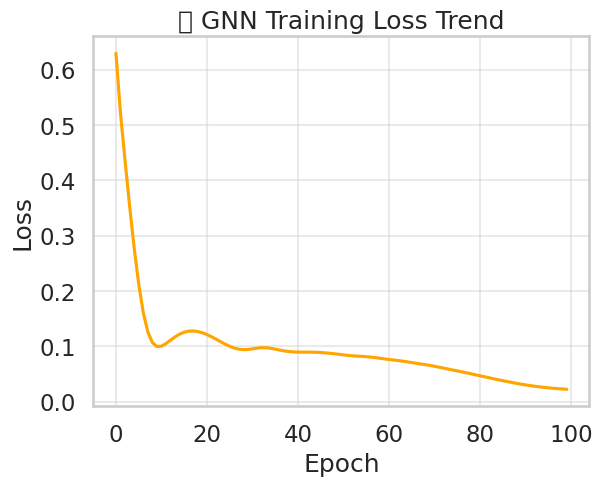

/usr/local/lib/python3.12/dist-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/tmp/ipython-input-495990479.py:192: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


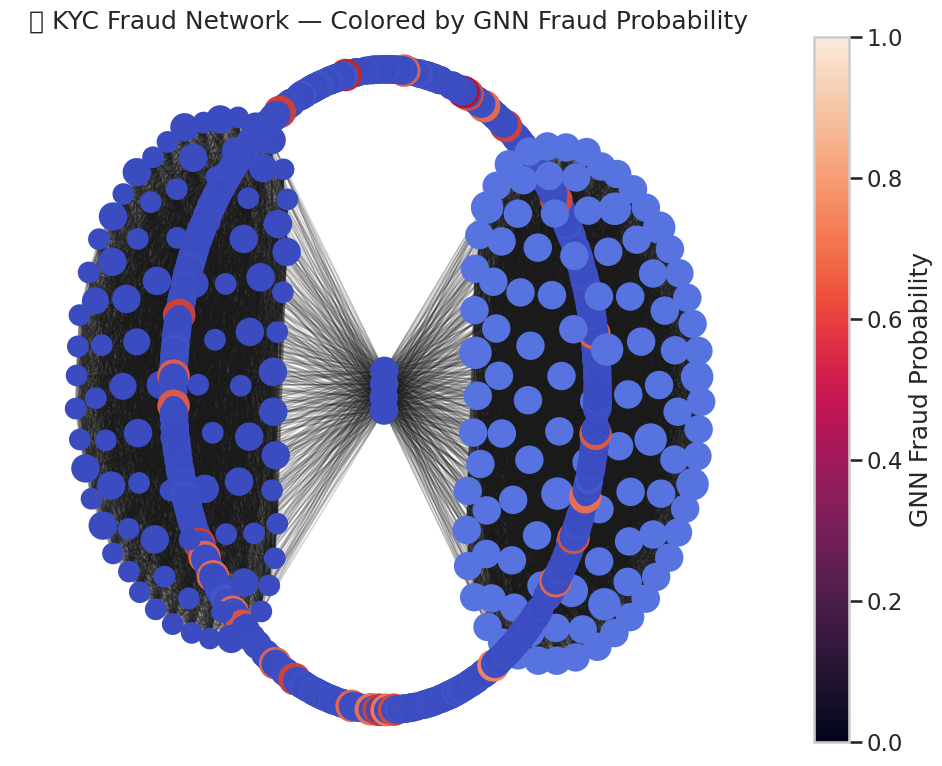


⚠️ Top Suspicious Records Detected by GNN:



,Name,Address,Fraud_Risk_Score,Fraud_Risk_Level,GNN_Fraud_Probability
380,Anahita Bajwa,"87, Ram Path, Bongaigaon 445142",0.7,High,0.988103
560,Abram Hegde,"H.No. 46, Bhasin Path, Gwalior 361323",0.7,High,0.968584
1500,Yasmin Kadakia,"93/35, Bhatt Path, Mira-Bhayandar 850022",0.7,High,0.954384
1491,Rhea Madan,"H.No. 59, Sarraf, Bhavnagar 576903",0.7,High,0.936206
1160,Shanaya Madan,"H.No. 45, Shukla Street, Katihar 830358",0.7,High,0.935780
925,Yasmin Bhargava,"595, Sen Chowk, Sikar-797420",0.7,High,0.930912
666,Riya Rajan,"H.No. 28, Krishnamurthy Path, Barasat-534619",0.7,High,0.930785
1359,Anvi Raval,"H.No. 23, D’Alia Path, Hubli–Dharwad 920964",0.7,High,0.928912
308,Hunar Dayal,"H.No. 97, Barad Ganj, Nadiad-239635",0.7,High,0.925940
202,Ishaan Tailor,"064, Tandon Path, Rajpur Sonarpur-874995",0.7,High,0.917823


/tmp/ipython-input-495990479.py:214: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


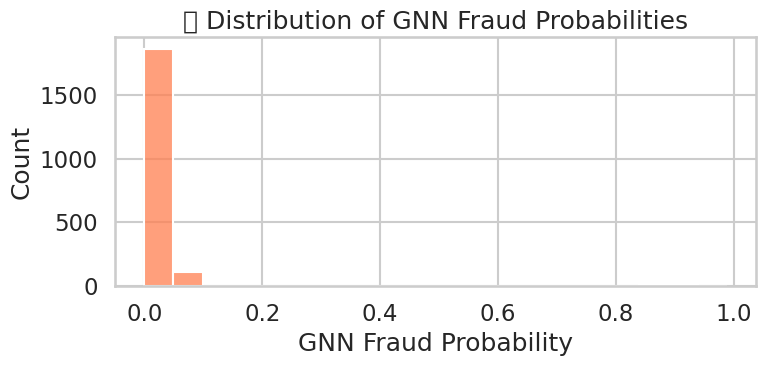


✅ Results saved to: /content/kyc_gnn_results.csv


In [ ]:
 # ===========================================================
# 🧠 KYC FRAUD DETECTION USING GNN (FINAL VERSION)
# ===========================================================
# Author: ChatGPT (Custom-tuned for Himani)
# Description: This pipeline creates a graph of KYC records,
# trains a GNN to learn fraud patterns, and visualizes results.

# -----------------------------------------------------------
# STEP 0️⃣: IMPORT LIBRARIES
# -----------------------------------------------------------
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
from torch.nn import Linear

# -----------------------------------------------------------
# STEP 1️⃣: LOAD DATA
# -----------------------------------------------------------
# Load your preprocessed KYC dataset
df = pd.read_csv('/content/sample_data/Output_of_modelling_part1.csv')

# Required columns check
required_cols = [
    'Name', 'Gender', 'DOB', 'Document_Type', 'Document_Number', 'Address',
    'Name_clean', 'Address_clean', 'Gender_clean', 'Document_type_clean',
    'Combined_Data', 'Fraud_Risk_Score', 'Fraud_Risk_Level'
]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing column: {c}")
#NaN is a float, not a string so filling the Nan values with emty string.
df = df.fillna('')

# -----------------------------------------------------------
# STEP 2️⃣: ENCODE & FEATURE ENGINEERING
# -----------------------------------------------------------

# Encode categorical fields (gender, document type)
le_gender = LabelEncoder()
le_doc = LabelEncoder()
df['Gender_encoded'] = le_gender.fit_transform(df['Gender_clean'])
df['DocType_encoded'] = le_doc.fit_transform(df['Document_type_clean'])

# Generate numeric pattern-based features from Document_Number
df['DocNum_length'] = df['Document_Number'].astype(str).apply(len)
df['DocNum_digits'] = df['Document_Number'].astype(str).str.count(r'\d')
df['DocNum_uppercase'] = df['Document_Number'].astype(str).apply(
    lambda x: sum(c.isupper() for c in x)
)

# -----------------------------------------------------------
# STEP 3️⃣: CREATE TEXT EMBEDDINGS (for semantic similarity)
# -----------------------------------------------------------

# 3a. Address embeddings (to capture geographic similarity)
tfidf_addr = TfidfVectorizer(max_features=300, ngram_range=(1, 2))
X_addr = tfidf_addr.fit_transform(df['Address_clean'])
svd_addr = TruncatedSVD(n_components=16, random_state=42)
X_addr_embed = svd_addr.fit_transform(X_addr)

# 3b. Combined_Data embeddings (captures full profile)
tfidf_combined = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_combined = tfidf_combined.fit_transform(df['Combined_Data'])
svd_combined = TruncatedSVD(n_components=32, random_state=42)
X_combined_embed = svd_combined.fit_transform(X_combined)

# -----------------------------------------------------------
# STEP 4️⃣: COMBINE ALL FEATURES INTO ONE MATRIX
# -----------------------------------------------------------
X_features = np.concatenate([
    X_combined_embed,              # semantic text info
    X_addr_embed,                  # address embeddings
    df[['Fraud_Risk_Score',        # numeric risk score
        'Gender_encoded',
        'DocType_encoded',
        'DocNum_length',
        'DocNum_digits',
        'DocNum_uppercase']].values
], axis=1)

# Normalize all features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_features)

# -----------------------------------------------------------
# STEP 5️⃣: BUILD THE GRAPH STRUCTURE
# -----------------------------------------------------------
G = nx.Graph()

# Add nodes (each record = 1 node)
for idx, row in df.iterrows():
    G.add_node(idx,
               name=row['Name_clean'],
               gender=row['Gender_clean'],
               doc_type=row['Document_type_clean'],
               fraud_score=row['Fraud_Risk_Score'])

# Add edges based on shared attributes (same address or document)
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        if (df.loc[i, 'Address_clean'] == df.loc[j, 'Address_clean']) or \
           (df.loc[i, 'Document_Number'] == df.loc[j, 'Document_Number']):
            G.add_edge(i, j, relation='shared_info')

# -----------------------------------------------------------
# STEP 6️⃣: CONVERT GRAPH TO GNN FORMAT (PyTorch Geometric)
# -----------------------------------------------------------
data = from_networkx(G)
data.x = torch.tensor(X_scaled, dtype=torch.float)
data.y = torch.tensor((df['Fraud_Risk_Level'] == 'High').astype(int).values)

# -----------------------------------------------------------
# STEP 7️⃣: DEFINE THE GNN MODEL
# -----------------------------------------------------------
class FraudGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FraudGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.linear = Linear(output_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.linear(x)
        return torch.sigmoid(x)

# -----------------------------------------------------------
# STEP 8️⃣: TRAIN THE MODEL
# -----------------------------------------------------------
model = FraudGNN(input_dim=data.x.shape[1], hidden_dim=64, output_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCELoss()

losses = []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.view(-1), data.y.float())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

# Plot loss curve
plt.plot(losses, color='orange')
plt.title("🧩 GNN Training Loss Trend")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.4)
plt.show()

# -----------------------------------------------------------
# STEP 9️⃣: GENERATE FRAUD PROBABILITIES
# -----------------------------------------------------------
model.eval()
with torch.no_grad():
    predictions = model(data).view(-1).numpy()

df['GNN_Fraud_Probability'] = predictions

# -----------------------------------------------------------
# STEP 🔟: VISUALIZE THE FRAUD GRAPH
# -----------------------------------------------------------
plt.figure(figsize=(10, 8))
pos = nx.kamada_kawai_layout(G, scale=2)

gnn_probs = np.array([df.loc[n, 'GNN_Fraud_Probability'] for n in G.nodes()])
rule_scores = np.array([df.loc[n, 'Fraud_Risk_Score'] for n in G.nodes()])

node_colors = plt.cm.coolwarm(gnn_probs)
node_sizes = 200 + 400 * rule_scores

nx.draw_networkx_edges(G, pos, alpha=0.2)
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, cmap='coolwarm')
plt.colorbar(nodes, label='GNN Fraud Probability')
plt.title("🔍 KYC Fraud Network — Colored by GNN Fraud Probability")
plt.axis('off')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# STEP 1️⃣1️⃣: TOP SUSPICIOUS RECORDS (BY GNN PROB)
# -----------------------------------------------------------
topk = 10
top_df = df.sort_values('GNN_Fraud_Probability', ascending=False).head(topk)[
    ['Name', 'Address', 'Fraud_Risk_Score', 'Fraud_Risk_Level', 'GNN_Fraud_Probability']
]

print("\n⚠️ Top Suspicious Records Detected by GNN:\n")
display(top_df)

# -----------------------------------------------------------
# STEP 1️⃣2️⃣: DISTRIBUTION OF GNN FRAUD PROBABILITIES
# -----------------------------------------------------------
plt.figure(figsize=(8, 4))
sns.histplot(df['GNN_Fraud_Probability'], bins=20, color='coral')
plt.title('📊 Distribution of GNN Fraud Probabilities')
plt.xlabel('GNN Fraud Probability')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# STEP 1️⃣3️⃣: SAVE OUTPUT (OPTIONAL)
# -----------------------------------------------------------
df.to_csv('/content/kyc_gnn_results.csv', index=False)
print("\n✅ Results saved to: /content/kyc_gnn_results.csv")


Another

Epoch 0 | Loss: 0.6686
Epoch 10 | Loss: 0.1957
Epoch 20 | Loss: 0.1211
Epoch 30 | Loss: 0.1176
Epoch 40 | Loss: 0.0980
Epoch 50 | Loss: 0.0980
Epoch 60 | Loss: 0.0939
Epoch 70 | Loss: 0.0917
Epoch 80 | Loss: 0.0888
Epoch 90 | Loss: 0.0858


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


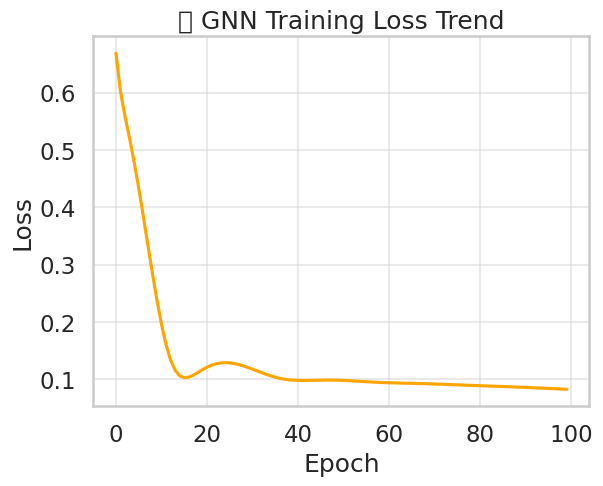

/tmp/ipython-input-117374903.py:188: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


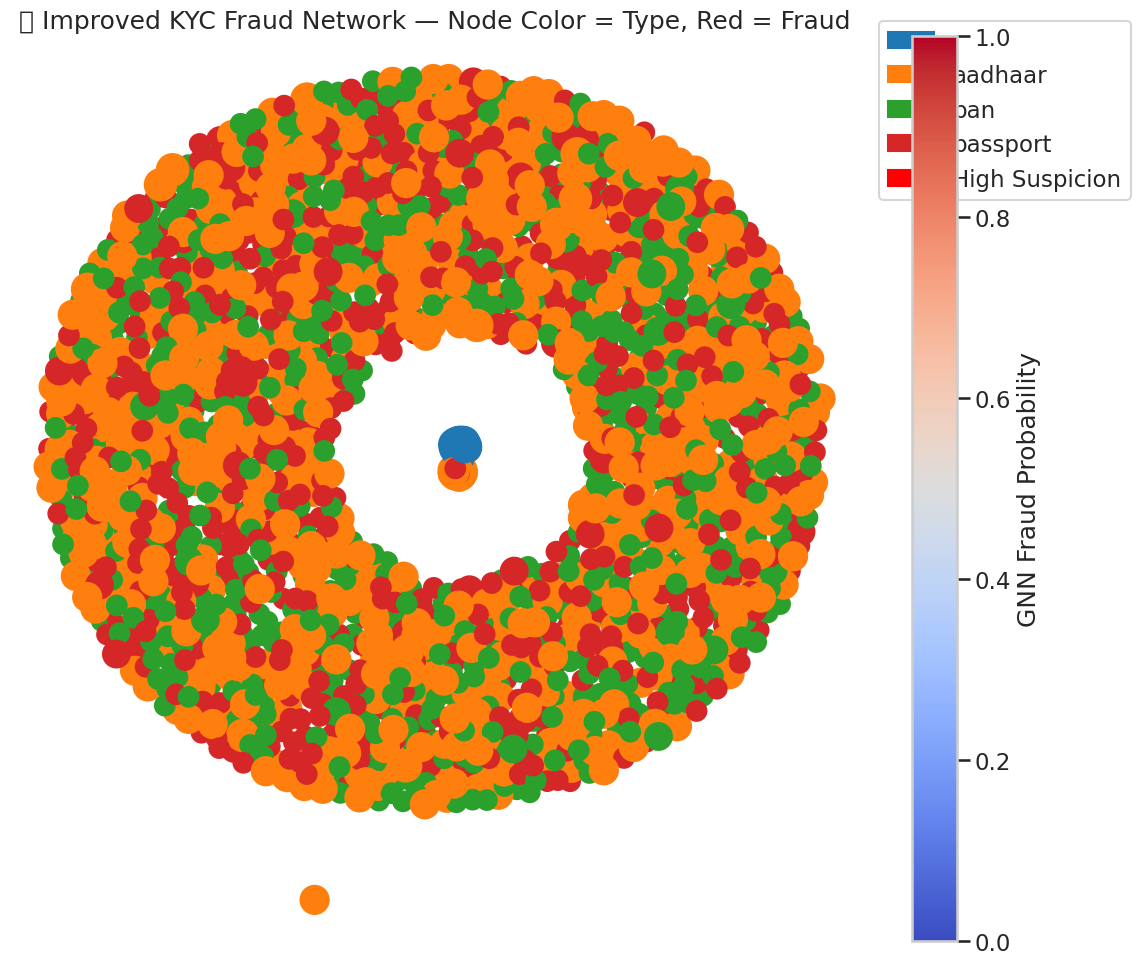


⚠️ Top Suspicious Records Detected by GNN:

                 Name                                    Address  \
380     Anahita Bajwa            87, Ram Path, Bongaigaon 445142   
1326       Saira Loke        209, Dutt Ganj, Narasaraopet-593953   
346   Divit Kuruvilla       88/354, Soman Circle, Madurai-564331   
1500   Yasmin Kadakia   93/35, Bhatt Path, Mira-Bhayandar 850022   
373     Nirvaan Bhatt            02, Char Road, Burhanpur 239489   
308       Hunar Dayal        H.No. 97, Barad Ganj, Nadiad-239635   
1264      Sumer Chand     40, Batra Road, Rajpur Sonarpur-271504   
1016     Purab Tiwari      36/66, Cheema Circle, Tinsukia 038147   
202     Ishaan Tailor   064, Tandon Path, Rajpur Sonarpur-874995   
1513      Nirvaan Ben  H.No. 666, Bhagat Circle, Vadodara 635864   

      Fraud_Risk_Score Fraud_Risk_Level  GNN_Fraud_Probability  
380                0.7             High               0.072374  
1326               0.7             High               0.060539  
346        

/tmp/ipython-input-117374903.py:210: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


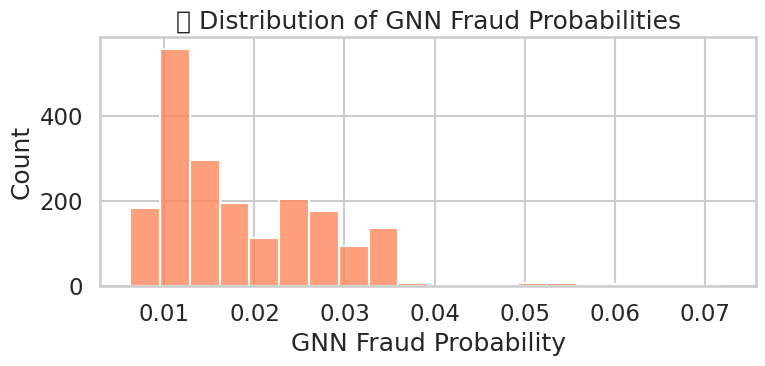


✅ Results saved to: /content/kyc_gnn_results.csv


In [ ]:
# ===========================================================
# 🧠 KYC FRAUD DETECTION USING GNN (IMPROVED VISUALIZATION)
# ===========================================================

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
from torch.nn import Linear

# --------------------------------------
# STEP 1: LOAD DATA
# --------------------------------------
df = pd.read_csv('/content/sample_data/Output_of_modelling_part1.csv')
df = df.fillna('')

required_cols = [
    'Name', 'Gender', 'DOB', 'Document_Type', 'Document_Number', 'Address',
    'Name_clean', 'Address_clean', 'Gender_clean', 'Document_type_clean',
    'Combined_Data', 'Fraud_Risk_Score', 'Fraud_Risk_Level'
]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing column: {c}")

# --------------------------------------
# STEP 2: ENCODE & FEATURE ENGINEERING
# --------------------------------------
le_gender = LabelEncoder()
le_doc = LabelEncoder()

df['Gender_encoded'] = le_gender.fit_transform(df['Gender_clean'])
df['DocType_encoded'] = le_doc.fit_transform(df['Document_type_clean'])

df['DocNum_length'] = df['Document_Number'].astype(str).apply(len)
df['DocNum_digits'] = df['Document_Number'].astype(str).str.count(r'\d')
df['DocNum_uppercase'] = df['Document_Number'].astype(str).apply(
    lambda x: sum(c.isupper() for c in x)
)

# --------------------------------------
# STEP 3: TEXT EMBEDDINGS (TF-IDF + SVD)
# --------------------------------------
tfidf_addr = TfidfVectorizer(max_features=300, ngram_range=(1, 2))
X_addr = tfidf_addr.fit_transform(df['Address_clean'])
svd_addr = TruncatedSVD(n_components=16, random_state=42)
X_addr_embed = svd_addr.fit_transform(X_addr)

tfidf_combined = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_combined = tfidf_combined.fit_transform(df['Combined_Data'])
svd_combined = TruncatedSVD(n_components=32, random_state=42)
X_combined_embed = svd_combined.fit_transform(X_combined)

# --------------------------------------
# STEP 4: COMBINE FEATURES
# --------------------------------------
X_features = np.concatenate([
    X_combined_embed,
    X_addr_embed,
    df[['Fraud_Risk_Score', 'Gender_encoded', 'DocType_encoded',
       'DocNum_length', 'DocNum_digits', 'DocNum_uppercase']].values
], axis=1)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_features)

# --------------------------------------
# STEP 5: BUILD THE GRAPH STRUCTURE
# --------------------------------------
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, name=row['Name_clean'], gender=row['Gender_clean'],
               doc_type=row['Document_type_clean'],
               fraud_score=row['Fraud_Risk_Score'])

for i in range(len(df)):
    for j in range(i + 1, len(df)):
        if (df.loc[i, 'Address_clean'] == df.loc[j, 'Address_clean']) or \
           (df.loc[i, 'Document_Number'] == df.loc[j, 'Document_Number']):
            G.add_edge(i, j, relation='shared_info')

# --------------------------------------
# STEP 6: GRAPH->GNN FORMAT
# --------------------------------------
from torch_geometric.utils import from_networkx

data = from_networkx(G)
data.x = torch.tensor(X_scaled, dtype=torch.float)
data.y = torch.tensor((df['Fraud_Risk_Level'] == 'High').astype(int).values)

# --------------------------------------
# STEP 7: DEFINE & TRAIN GNN MODEL
# --------------------------------------
class FraudGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FraudGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.linear = Linear(output_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.linear(x)
        return torch.sigmoid(x)

model = FraudGNN(input_dim=data.x.shape[1], hidden_dim=64, output_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCELoss()

losses = []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.view(-1), data.y.float())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

plt.plot(losses, color='orange')
plt.title("🧩 GNN Training Loss Trend")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.4)
plt.show()

# --------------------------------------
# STEP 8: FRAUD PROBABILITIES
# --------------------------------------
model.eval()
with torch.no_grad():
    predictions = model(data).view(-1).numpy()

df['GNN_Fraud_Probability'] = predictions

# --------------------------------------
# STEP 9: IMPROVED VISUALIZATION
# --------------------------------------
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 10))
ax = plt.gca() # Get the current axes
pos = nx.spring_layout(G, seed=42, k=0.2)

# Node features for improved plotting
gnn_probs = np.array([df.loc[n, 'GNN_Fraud_Probability'] for n in G.nodes()])
rule_scores = np.array([df.loc[n, 'Fraud_Risk_Score'] for n in G.nodes()])
node_types = [df.loc[n, 'Document_type_clean'] for n in G.nodes()]

# Use a robust color palette from seaborn, supporting any/unknown doc types
unique_types = list(sorted(set(node_types)))
colors_map = sns.color_palette('tab10', n_colors=len(unique_types))
type_palette = dict(zip(unique_types, colors_map))

colors = [type_palette.get(t, (0.7,0.7,0.7)) for t in node_types]
high_fraud = (gnn_probs > 0.8)
for idx, high in enumerate(high_fraud):
    if high:
        colors[idx] = (1,0,0)  # Pure red

node_sizes = 200 + 400 * (rule_scores**0.7)

nx.draw_networkx_edges(G, pos, alpha=0.07, width=0.8)
nodes = nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_sizes)

legend_patches = [mpatches.Patch(color=type_palette[t], label=t) for t in unique_types]
legend_patches.append(mpatches.Patch(color='red', label='High Suspicion'))
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.01, 1.03))
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=ax, label='GNN Fraud Probability') # Pass the axes object here

plt.title("🔍 Improved KYC Fraud Network — Node Color = Type, Red = Fraud")
plt.axis('off')
plt.tight_layout()
plt.show()

# --------------------------------------
# STEP 10: TOP SUSPICIOUS RECORDS
# --------------------------------------
topk = 10
top_df = df.sort_values('GNN_Fraud_Probability', ascending=False).head(topk)[
    ['Name', 'Address', 'Fraud_Risk_Score', 'Fraud_Risk_Level', 'GNN_Fraud_Probability']
]

print("\n⚠️ Top Suspicious Records Detected by GNN:\n")
print(top_df)

# --------------------------------------
# STEP 11: DISTRIBUTION
# --------------------------------------
plt.figure(figsize=(8, 4))
sns.histplot(df['GNN_Fraud_Probability'], bins=20, color='coral')
plt.title('📊 Distribution of GNN Fraud Probabilities')
plt.xlabel('GNN Fraud Probability')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

df.to_csv('/content/kyc_gnn_results.csv', index=False)
print("\n✅ Results saved to: /content/kyc_gnn_results.csv")

Epoch 0 | Loss: 0.5985
Epoch 10 | Loss: 0.1122
Epoch 20 | Loss: 0.1266
Epoch 30 | Loss: 0.0988
Epoch 40 | Loss: 0.0964
Epoch 50 | Loss: 0.0924
Epoch 60 | Loss: 0.0870
Epoch 70 | Loss: 0.0806
Epoch 80 | Loss: 0.0733
Epoch 90 | Loss: 0.0641


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


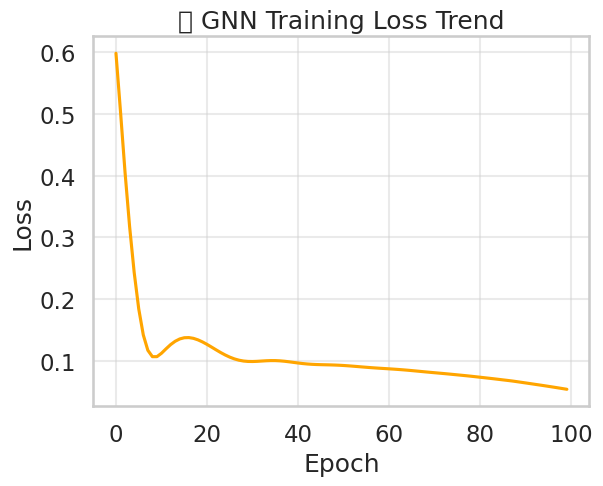

/tmp/ipython-input-1589149036.py:192: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


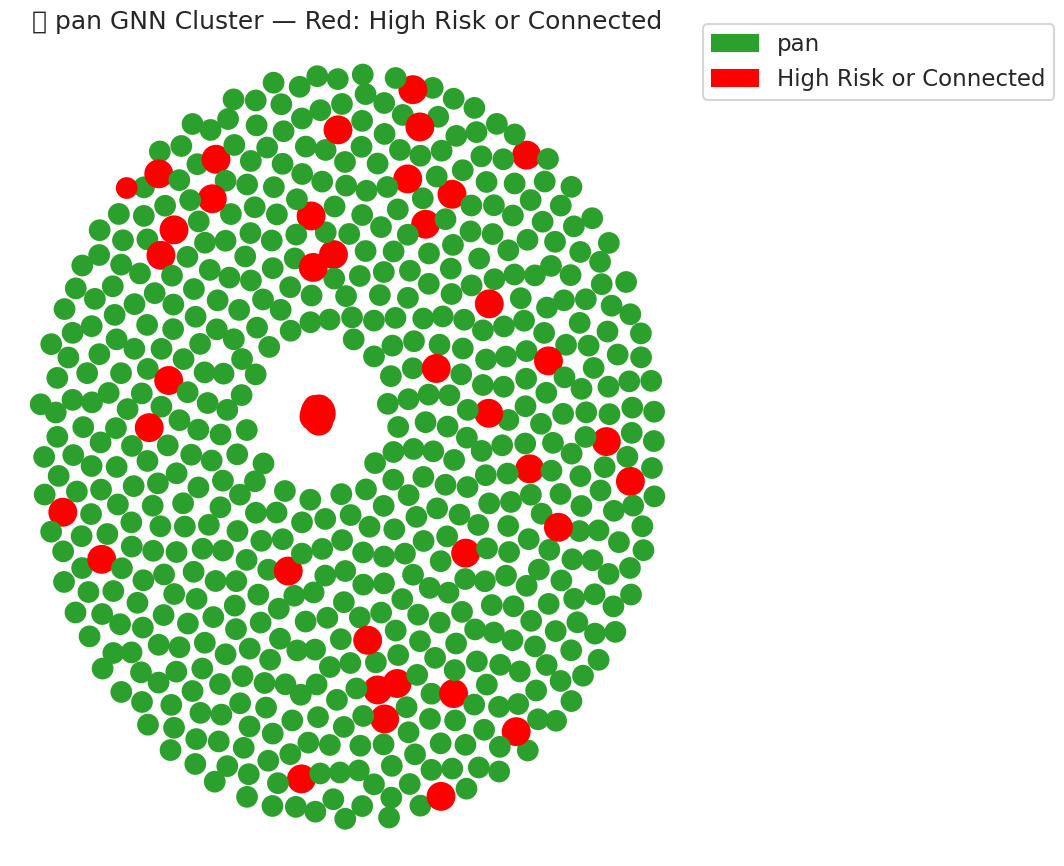

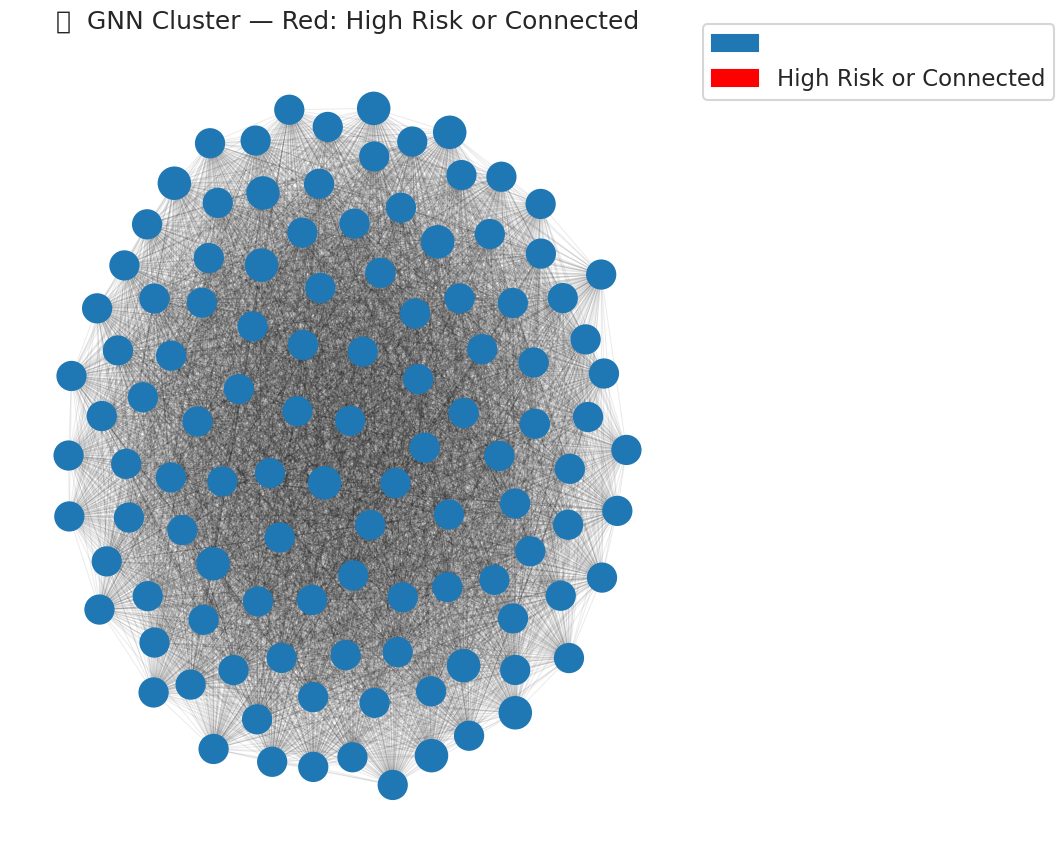

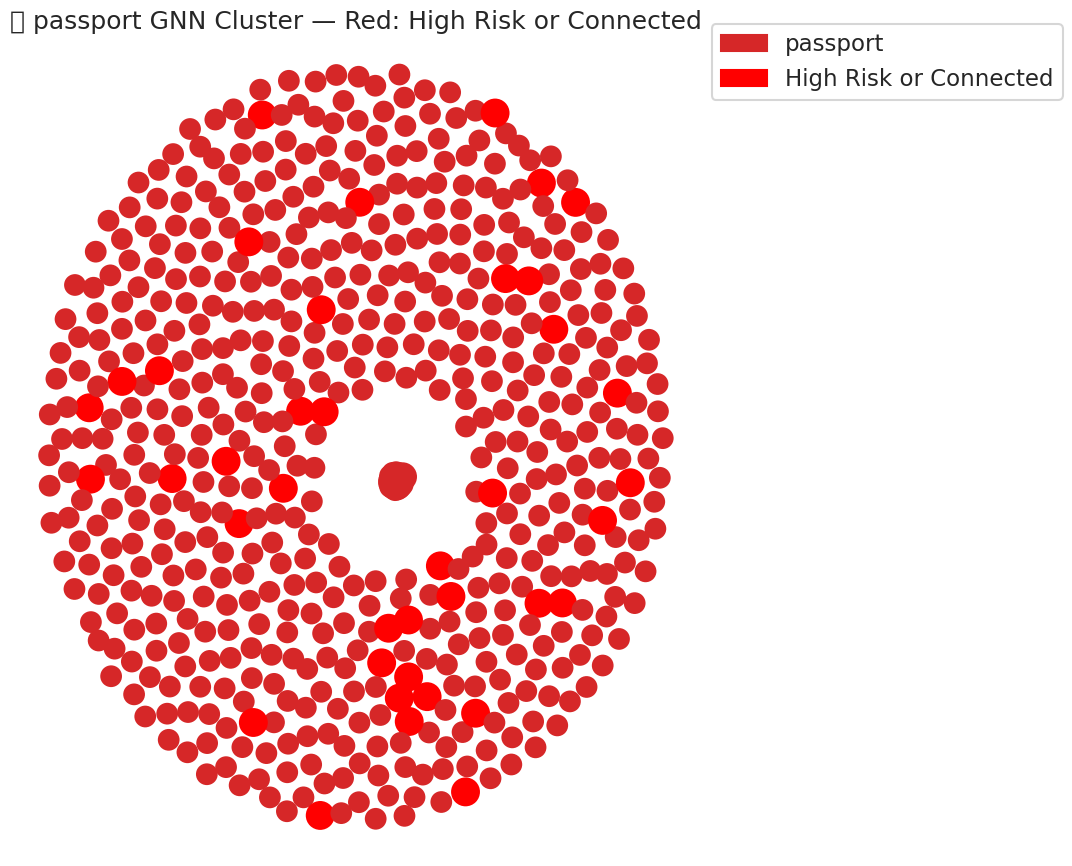

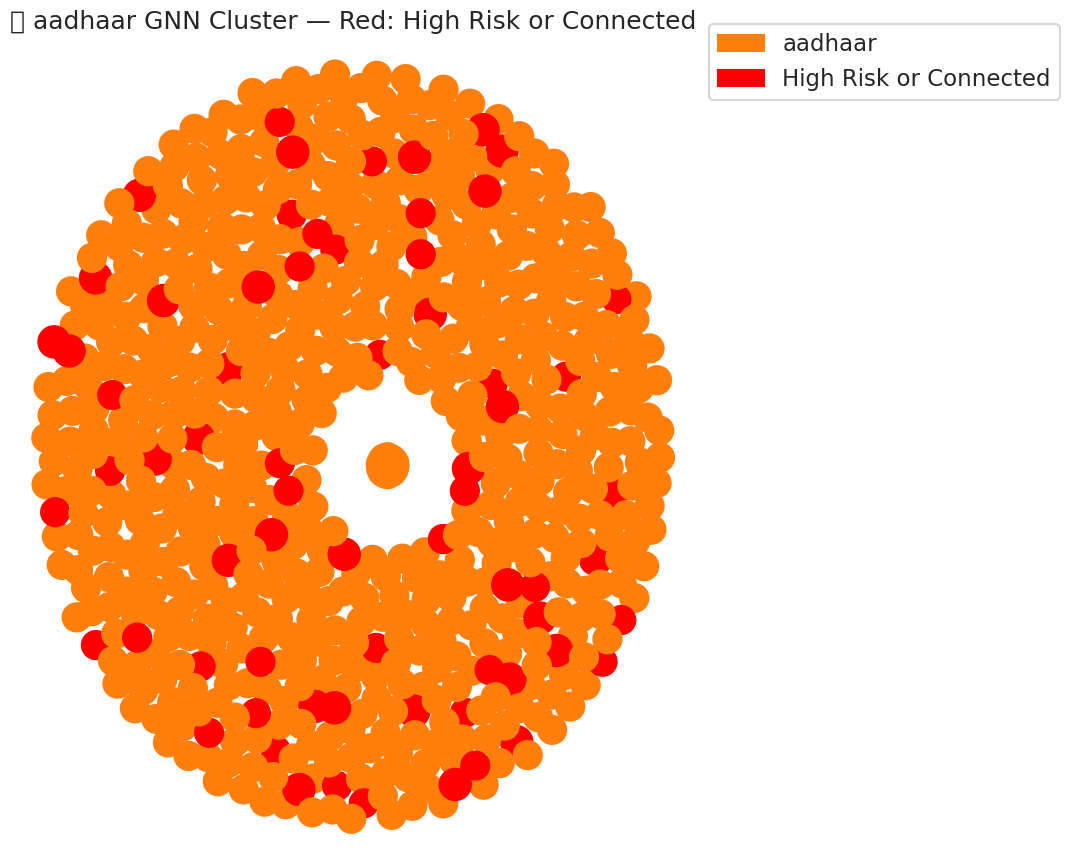

In [ ]:
import matplotlib.patches as mpatches
# --------------------------------------
# STEP 1: LOAD DATA
# --------------------------------------
df = pd.read_csv('/content/sample_data/Output_of_modelling_part1.csv')
df = df.fillna('')

required_cols = [
    'Name', 'Gender', 'DOB', 'Document_Type', 'Document_Number', 'Address',
    'Name_clean', 'Address_clean', 'Gender_clean', 'Document_type_clean',
    'Combined_Data', 'Fraud_Risk_Score', 'Fraud_Risk_Level'
]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing column: {c}")

# --------------------------------------
# STEP 2: ENCODE & FEATURE ENGINEERING
# --------------------------------------
le_gender = LabelEncoder()
le_doc = LabelEncoder()

df['Gender_encoded'] = le_gender.fit_transform(df['Gender_clean'])
df['DocType_encoded'] = le_doc.fit_transform(df['Document_type_clean'])

df['DocNum_length'] = df['Document_Number'].astype(str).apply(len)
df['DocNum_digits'] = df['Document_Number'].astype(str).str.count(r'\d')
df['DocNum_uppercase'] = df['Document_Number'].astype(str).apply(
    lambda x: sum(c.isupper() for c in x)
)

# --------------------------------------
# STEP 3: TEXT EMBEDDINGS (TF-IDF + SVD)
# --------------------------------------
tfidf_addr = TfidfVectorizer(max_features=300, ngram_range=(1, 2))
X_addr = tfidf_addr.fit_transform(df['Address_clean'])
svd_addr = TruncatedSVD(n_components=16, random_state=42)
X_addr_embed = svd_addr.fit_transform(X_addr)

tfidf_combined = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_combined = tfidf_combined.fit_transform(df['Combined_Data'])
svd_combined = TruncatedSVD(n_components=32, random_state=42)
X_combined_embed = svd_combined.fit_transform(X_combined)

# --------------------------------------
# STEP 4: COMBINE FEATURES
# --------------------------------------
X_features = np.concatenate([
    X_combined_embed,
    X_addr_embed,
    df[['Fraud_Risk_Score', 'Gender_encoded', 'DocType_encoded',
       'DocNum_length', 'DocNum_digits', 'DocNum_uppercase']].values
], axis=1)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_features)

# --------------------------------------
# STEP 5: BUILD THE GRAPH STRUCTURE
# --------------------------------------
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, name=row['Name_clean'], gender=row['Gender_clean'],
               doc_type=row['Document_type_clean'],
               fraud_score=row['Fraud_Risk_Score'])

for i in range(len(df)):
    for j in range(i + 1, len(df)):
        if (df.loc[i, 'Address_clean'] == df.loc[j, 'Address_clean']) or \
           (df.loc[i, 'Document_Number'] == df.loc[j, 'Document_Number']):
            G.add_edge(i, j, relation='shared_info')

# --------------------------------------
# STEP 6: GRAPH->GNN FORMAT
# --------------------------------------
from torch_geometric.utils import from_networkx

data = from_networkx(G)
data.x = torch.tensor(X_scaled, dtype=torch.float)
data.y = torch.tensor((df['Fraud_Risk_Level'] == 'High').astype(int).values)

# --------------------------------------
# STEP 7: DEFINE & TRAIN GNN MODEL
# --------------------------------------
class FraudGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FraudGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.linear = Linear(output_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.linear(x)
        return torch.sigmoid(x)

model = FraudGNN(input_dim=data.x.shape[1], hidden_dim=64, output_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCELoss()

losses = []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.view(-1), data.y.float())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

plt.plot(losses, color='orange')
plt.title("🧩 GNN Training Loss Trend")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.4)
plt.show()
# --------------------------------------
# STEP 8: FRAUD PROBABILITIES
# --------------------------------------
model.eval()
with torch.no_grad():
    predictions = model(data).view(-1).numpy()

df['GNN_Fraud_Probability'] = predictions

# -----------------------------------------------------------
# STEP 9: DOCUMENT-TYPE-SPECIFIC GNN VISUALIZATION
# -----------------------------------------------------------

# Use a robust color palette from seaborn, supporting any/unknown doc types
unique_types = list(sorted(set(df['Document_type_clean'].unique())))
colors_map = sns.color_palette('tab10', n_colors=len(unique_types))
type_palette = dict(zip(unique_types, colors_map))


def plot_gnn_clusters_by_type(doc_type):
    # Filter to only the current document type
    type_mask = np.array([t == doc_type for t in df['Document_type_clean']])
    nodes_to_keep = np.where(type_mask)[0]

    # Only plot if there are nodes of this type
    if len(nodes_to_keep) == 0:
        print(f"No records found for document type: {doc_type}. Skipping plot.")
        return

    # Induce subgraph for doc_type
    G_sub = G.subgraph(nodes_to_keep)

    # Choose layout - spring layout is good for showing clusters/structure
    pos = nx.spring_layout(G_sub, seed=42, k=0.2, iterations=50) # Increased iterations for better spread

    # Recalculate attributes for subgraph
    gnn_probs_sub = np.array([df.loc[n, 'GNN_Fraud_Probability'] for n in G_sub.nodes()])
    rule_scores_sub = np.array([df.loc[n, 'Fraud_Risk_Score'] for n in G_sub.nodes()])

    # Determine threshold for 'High Risk' dynamically (e.g., top 10%)
    threshold = np.percentile(gnn_probs_sub, 90) if len(gnn_probs_sub) > 0 else 0.0

    # Find risky/fraud nodes (red)
    fraud_nodes = [n for n, p in zip(G_sub.nodes(), gnn_probs_sub) if p > threshold]
    connected_to_fraud = set()
    # Collect nodes directly connected to any fraud node in this subgraph
    for fn in fraud_nodes:
        connected_to_fraud.update(list(G_sub.neighbors(fn)))

    colors = []
    for n in G_sub.nodes():
        if n in fraud_nodes or n in connected_to_fraud:
            colors.append('red')
        else:
            # Use the palette color for the specific document type
            colors.append(type_palette.get(df.loc[n, 'Document_type_clean'], (0.7, 0.7, 0.7)))


    node_sizes = 200 + 400 * (rule_scores_sub**0.7)

    plt.figure(figsize=(11, 9))
    ax = plt.gca() # Get current axes for colorbar
    nx.draw_networkx_edges(G_sub, pos, alpha=0.09, width=0.7)
    nodes = nx.draw_networkx_nodes(G_sub, pos, node_color=colors, node_size=node_sizes)

    legend_patches = [mpatches.Patch(color=type_palette.get(doc_type, (0.7,0.7,0.7)), label=doc_type),
                      mpatches.Patch(color='red', label='High Risk or Connected')]
    plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.01, 1.03))

    plt.title(f"🔍 {doc_type} GNN Cluster — Red: High Risk or Connected")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Run visualizations for each document type in your data
for doc_type in set(df['Document_type_clean'].unique()):
    plot_gnn_clusters_by_type(doc_type)

In [ ]:
# Clean relevant columns before edge creation
for col in ["Address_clean", "Document_Number"]:
    df[col] = df[col].fillna("unknown").astype(str).str.lower().str.strip()
    df.loc[df[col] == "", col] = "unknown"

# Rebuild edges
print("Adding edges by Address_clean:")
for addr, group in tqdm(df.groupby("Address_clean")):
    if len(group) > 1:
        for i in range(len(group) - 1):
            G.add_edge(group.index[i], group.index[i+1])

print("Adding edges by Document_Number:")
for doc, group in tqdm(df.groupby("Document_Number")):
    if len(group) > 1:
        for i in range(len(group) - 1):
            G.add_edge(group.index[i], group.index[i+1])

print(f"✅ Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Adding edges by Address_clean:


100%|██████████| 1905/1905 [00:00<00:00, 11874.20it/s]


Adding edges by Document_Number:


100%|██████████| 1889/1889 [00:00<00:00, 13142.18it/s]

✅ Graph built with 2000 nodes and 206 edges.


✅ Loaded dataset with 2000 rows.


Building edges: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


📊 Graph Summary: 2000 nodes | 0 edges
Epoch 0 | Loss: 30.7111
Epoch 10 | Loss: 5.0676
Epoch 20 | Loss: 6.4337
Epoch 30 | Loss: 4.5579
Epoch 40 | Loss: 4.5920
Epoch 50 | Loss: 4.2565


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.



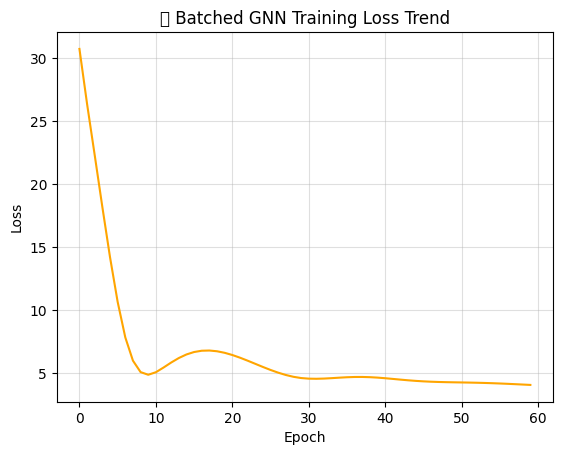

✅ Done! Predictions saved in df['GNN_Fraud_Probability']


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import torch
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import concurrent.futures

# ==========================================
# STEP 1: LOAD DATA
# ==========================================
df = pd.read_csv('/content/sample_data/Output_of_modelling_part1.csv').fillna('')
print(f"✅ Loaded dataset with {len(df)} rows.")

# ==========================================
# STEP 2: FEATURE ENGINEERING
# ==========================================
le_gender = LabelEncoder()
le_doc = LabelEncoder()
df['Gender_encoded'] = le_gender.fit_transform(df['Gender_clean'])
df['DocType_encoded'] = le_doc.fit_transform(df['Document_type_clean'])
df['DocNum_length'] = df['Document_Number'].astype(str).apply(len)
df['DocNum_digits'] = df['Document_Number'].astype(str).str.count(r'\d')
df['DocNum_uppercase'] = df['Document_Number'].astype(str).apply(lambda x: sum(c.isupper() for c in x))

# ==========================================
# STEP 3: BATCHED TF-IDF + SVD EMBEDDINGS
# ==========================================
def batched_tfidf_svd(texts, max_features=1000, n_components=32, batch_size=500):
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1,2))
    X_tfidf = vectorizer.fit_transform(texts[:1000])  # partial fit for vocab
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(X_tfidf)

    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding in batches"):
        batch = texts[i:i+batch_size]
        X = vectorizer.transform(batch)
        X_emb = svd.transform(X)
        all_embeddings.append(X_emb)
    return np.vstack(all_embeddings)

# Combined and Address embeddings (batched)
X_addr_embed = batched_tfidf_svd(df['Address_clean'], max_features=300, n_components=16)
X_combined_embed = batched_tfidf_svd(df['Combined_Data'], max_features=1000, n_components=32)

# ==========================================
# STEP 4: COMBINE + SCALE
# ==========================================
X_features = np.concatenate([
    X_combined_embed,
    X_addr_embed,
    df[['Fraud_Risk_Score', 'Gender_encoded', 'DocType_encoded',
        'DocNum_length', 'DocNum_digits', 'DocNum_uppercase']].values
], axis=1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_features)

# ==========================================
# STEP 5: FAST PARALLEL GRAPH CONSTRUCTION
# ==========================================
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, name=row['Name_clean'],
               gender=row['Gender_clean'],
               doc_type=row['Document_type_clean'],
               fraud_score=row['Fraud_Risk_Score'])

def add_edges_for_column_parallel(col_name):
    grouped = df.groupby(col_name)
    edges = []
    for key, group in grouped:
        if key == '' or len(group) < 2:
            continue
        idx = group.index.tolist()
        edges += [(idx[i], idx[j]) for i in range(len(idx)) for j in range(i+1, len(idx))]
    return edges

cols_to_link = ['Address_clean', 'Document_Number']

# Run edge building in parallel threads
all_edges = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(add_edges_for_column_parallel, cols_to_link),
                        total=len(cols_to_link), desc="Building edges"))
    for res in results:
        all_edges.extend(res)

G.add_edges_from(all_edges)
print(f"📊 Graph Summary: {G.number_of_nodes()} nodes | {G.number_of_edges()} edges")

# ==========================================
# STEP 6: LABELS
# ==========================================
df['label'] = (df['Fraud_Risk_Level'] == 'High').astype(int)
if df['label'].sum() == 0:
    idx = df.sample(max(10, len(df)//100), random_state=42).index
    df.loc[idx, 'label'] = 1

# ==========================================
# STEP 7: CONVERT TO GNN DATA
# ==========================================
data = from_networkx(G)
data.x = torch.tensor(X_scaled, dtype=torch.float)
data.y = torch.tensor(df['label'].values)

# ==========================================
# STEP 8: MODEL + TRAIN
# ==========================================
class FraudGNN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(FraudGNN, self).__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, out_dim)
        self.linear = Linear(out_dim, 1)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.linear(x)
        return torch.sigmoid(x)

model = FraudGNN(data.x.shape[1], 64, 32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
fraud_weight = max(1, (len(df)-df['label'].sum())/df['label'].sum())
criterion = torch.nn.BCELoss(weight=torch.tensor([fraud_weight]))
losses = []

for epoch in range(60):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.view(-1), data.y.float())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

plt.plot(losses, color='orange')
plt.title("🧩 Batched GNN Training Loss Trend")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(alpha=0.4)
plt.show()

# ==========================================
# STEP 9: PREDICT
# ==========================================
model.eval()
with torch.no_grad():
    preds = model(data).view(-1).numpy()
df['GNN_Fraud_Probability'] = preds
print("✅ Done! Predictions saved in df['GNN_Fraud_Probability']")


In [ ]:
df.head()

✅ Loaded dataset with 2000 rows.


Adding edges by Document_Number: 100%|██████████| 1889/1889 [00:00<00:00, 43095.84it/s]


📊 Optimized Graph Summary:
Nodes: 2000 | Edges: 0
Connected Components: 2000
Fraud Label Distribution:
 label
0    1958
1      42
Name: count, dtype: int64
Epoch 0 | Loss: 29.000187
Epoch 10 | Loss: 5.246763
Epoch 20 | Loss: 5.690508
Epoch 30 | Loss: 4.307598
Epoch 40 | Loss: 4.025589
Epoch 50 | Loss: 3.693483
Epoch 60 | Loss: 3.228355
Epoch 70 | Loss: 2.646976
Epoch 80 | Loss: 2.047623
Epoch 90 | Loss: 1.496444


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.



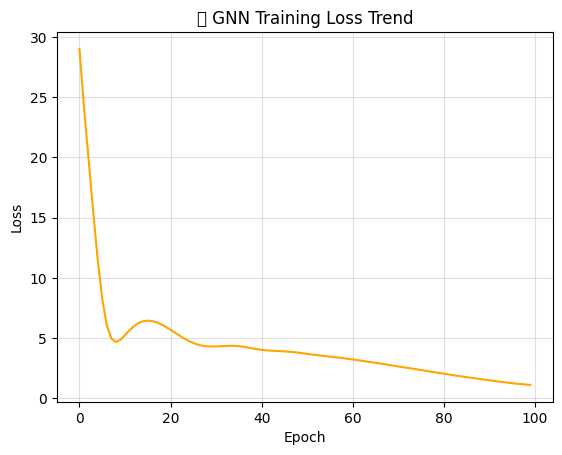

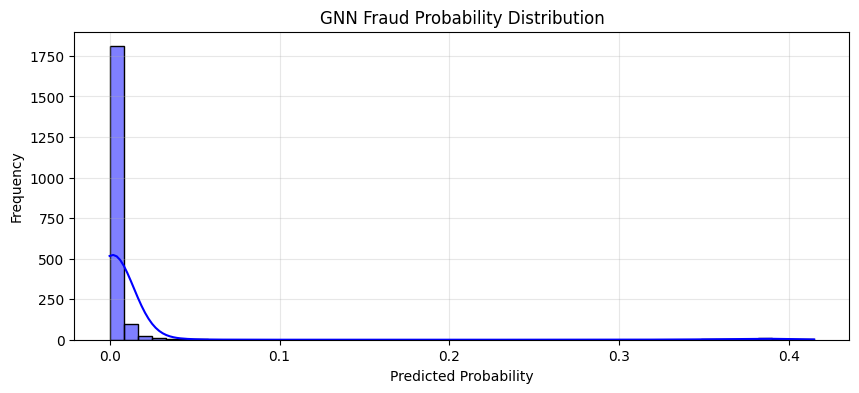

In [ ]:
# other one with weights , diff from prev one
# ==============================================
# 🧠 KYC FRAUD DETECTION USING GNN + FIXES
# ==============================================

import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import torch
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as pyo
import math
from tqdm import tqdm

# =====================================================
# STEP 1: LOAD & CHECK DATA
# =====================================================
df = pd.read_csv('/content/sample_data/Output_of_modelling_part1.csv')
df = df.fillna('')

required_cols = [
    'Name', 'Gender', 'DOB', 'Document_Type', 'Document_Number', 'Address',
    'Name_clean', 'Address_clean', 'Gender_clean', 'Document_type_clean',
    'Combined_Data', 'Fraud_Risk_Score', 'Fraud_Risk_Level'
]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing column: {c}")

print(f"✅ Loaded dataset with {len(df)} rows.")

# =====================================================
# STEP 2: FEATURE ENGINEERING
# =====================================================
le_gender = LabelEncoder()
le_doc = LabelEncoder()
df['Gender_encoded'] = le_gender.fit_transform(df['Gender_clean'])
df['DocType_encoded'] = le_doc.fit_transform(df['Document_type_clean'])
df['DocNum_length'] = df['Document_Number'].astype(str).apply(len)
df['DocNum_digits'] = df['Document_Number'].astype(str).str.count(r'\d')
df['DocNum_uppercase'] = df['Document_Number'].astype(str).apply(
    lambda x: sum(c.isupper() for c in x)
)

# =====================================================
# STEP 3: TEXT EMBEDDINGS (TF-IDF + SVD)
# =====================================================
tfidf_addr = TfidfVectorizer(max_features=300, ngram_range=(1, 2))
X_addr = tfidf_addr.fit_transform(df['Address_clean'])
svd_addr = TruncatedSVD(n_components=16, random_state=42)
X_addr_embed = svd_addr.fit_transform(X_addr)

tfidf_combined = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_combined = tfidf_combined.fit_transform(df['Combined_Data'])
svd_combined = TruncatedSVD(n_components=32, random_state=42)
X_combined_embed = svd_combined.fit_transform(X_combined)

# =====================================================
# STEP 4: COMBINE + SCALE FEATURES
# =====================================================
X_features = np.concatenate([
    X_combined_embed,
    X_addr_embed,
    df[['Fraud_Risk_Score', 'Gender_encoded', 'DocType_encoded',
       'DocNum_length', 'DocNum_digits', 'DocNum_uppercase']].values
], axis=1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_features)

# =====================================================
# STEP 5: BUILD GRAPH (CONNECT SIMILAR RECORDS)
# =====================================================
# =====================================================
# STEP 5 (Optimized): BUILD GRAPH USING BATCHES
# =====================================================


G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, name=row['Name_clean'],
               gender=row['Gender_clean'],
               doc_type=row['Document_type_clean'],
               fraud_score=row['Fraud_Risk_Score'])

# --- Helper: connect nodes that share address or doc number ---
def add_edges_for_column(df, col_name):
    grouped = df.groupby(col_name)
    for key, group in tqdm(grouped, desc=f"Adding edges by {col_name}"):
        if key == '' or len(group) < 2:
            continue
        indices = group.index.tolist()
        # Fully connect group (each node to every other in that group)
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                G.add_edge(indices[i], indices[j], relation=f'shared_{col_name}')

# Add edges for each key column
add_edges_for_column(df, 'Address_clean')
add_edges_for_column(df, 'Document_Number')

print("📊 Optimized Graph Summary:")
print("Nodes:", G.number_of_nodes(), "| Edges:", G.number_of_edges())
print("Connected Components:", nx.number_connected_components(G))


# =====================================================
# STEP 6: SYNTHETIC FRAUD LABEL INJECTION
# =====================================================
# Convert categorical fraud level to binary (High → 1, others → 0)
df['label'] = (df['Fraud_Risk_Level'] == 'High').astype(int)

# If no positive labels exist, inject synthetic ones
if df['label'].sum() == 0:
    print("⚠️ No fraud samples found — adding synthetic positives.")
    # Pick 1% of dataset or at least 10 samples
    n_samples = max(10, len(df)//100)
    high_risk_idx = df.sample(n_samples, random_state=42).index
    df.loc[high_risk_idx, 'label'] = 1

print("Fraud Label Distribution:\n", df['label'].value_counts())

# =====================================================
# STEP 7: CONVERT GRAPH TO GNN FORMAT
# =====================================================
data = from_networkx(G)
data.x = torch.tensor(X_scaled, dtype=torch.float)
data.y = torch.tensor(df['label'].values)

# =====================================================
# STEP 8: DEFINE THE GNN MODEL
# =====================================================
class FraudGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FraudGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.linear = Linear(output_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))   # 1st layer: feature propagation
        x = F.relu(self.conv2(x, edge_index))   # 2nd layer: deeper relations
        x = self.linear(x)                      # Linear layer → final prediction
        return torch.sigmoid(x)                 # Output fraud probability (0–1)

# =====================================================
# STEP 9: TRAIN THE GNN WITH CLASS WEIGHTING
# =====================================================
model = FraudGNN(input_dim=data.x.shape[1], hidden_dim=64, output_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Assign higher weight to fraud class (since it's rare)
fraud_weight = max(1, (len(df) - df['label'].sum()) / df['label'].sum())
criterion = torch.nn.BCELoss(weight=torch.tensor([fraud_weight]))

losses = []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.view(-1), data.y.float())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# =====================================================
# STEP 10: VISUALIZE TRAINING LOSS
# =====================================================
plt.plot(losses, color='orange')
plt.title("🧩 GNN Training Loss Trend")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.4)
plt.show()

# =====================================================
# STEP 11: PREDICT FRAUD PROBABILITIES
# =====================================================
model.eval()
with torch.no_grad():
    predictions = model(data).view(-1).numpy()

df['GNN_Fraud_Probability'] = predictions

# =====================================================
# STEP 12: VISUALIZE DISTRIBUTION (BEFORE/AFTER)
# =====================================================
plt.figure(figsize=(10,4))
sns.histplot(df['GNN_Fraud_Probability'], bins=50, color='blue', kde=True)
plt.title("GNN Fraud Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

# =====================================================
# STEP 13: INTERACTIVE GRAPH VISUALIZATION
# =====================================================
def plot_interactive_gnn_clusters(doc_type):
    nodes_to_keep = [n for n, v in G.nodes(data=True) if v['doc_type'] == doc_type]
    if not nodes_to_keep:
        print(f"No records found for document type {doc_type}")
        return

    G_sub = G.subgraph(nodes_to_keep)
    pos = nx.spring_layout(G_sub, seed=42, k=0.2, iterations=50)

    gnn_probs_sub = np.array([df.loc[n, 'GNN_Fraud_Probability'] for n in G_sub.nodes()])
    threshold = np.percentile(gnn_probs_sub, 90)
    fraud_nodes = [n for n, p in zip(G_sub.nodes(), gnn_probs_sub) if p > threshold]

    colors = ['rgba(255,0,0,0.8)' if n in fraud_nodes else 'rgba(30,144,255,0.7)'
              for n in G_sub.nodes()]

    node_x, node_y, custom_text = [], [], []
    for n in G_sub.nodes():
        x, y = pos[n]
        node_x.append(x)
        node_y.append(y)
        custom_text.append(f"{df.loc[n, 'Name_clean']}<br>Prob: {df.loc[n, 'GNN_Fraud_Probability']:.2f}")

    edge_x, edge_y = [], []
    for edge in G_sub.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.3, color='#888'),
                            hoverinfo='none', mode='lines')
    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers+text',
                            marker=dict(size=14, color=colors, line=dict(width=2)),
                            text=custom_text, hoverinfo='text')

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f'Interactive GNN Cluster for {doc_type}',
                        showlegend=False, hovermode='closest',
                        margin=dict(b=0,l=0,r=0,t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))
    pyo.iplot(fig)

for dt in set(df['Document_type_clean']):
    plot_interactive_gnn_clusters(dt)


In [ ]:
df.head()

,Name,Gender,DOB,Document_Type,Document_Number,Address,Name_clean,Address_clean,Gender_clean,Document_type_clean,...,Duplicate_Group_ID,Fraud_Risk_Score,Fraud_Risk_Level,Gender_encoded,DocType_encoded,DocNum_length,DocNum_digits,DocNum_uppercase,label,GNN_Fraud_Probability
0,Mohanlal Sinha,Other,04-08-1975,Passport,K3935412,"866, Borah Street, Hubli–Dharwad-639425",mohanlal sinha,866 borah street hublidharwad639425,other,passport,...,-1,0.0,Low,3,3,8,7,1,0,0.000037
1,Emir Gola,Male,12-03-1993,PAN,CCXHG1852M,"H.No. 19, De Zila, North Dumdum 451695",emir gola,hno 19 de zila north dumdum 451695,male,pan,...,-1,0.0,Low,2,2,10,4,6,0,0.000006
2,Krish D’Alia,Female,11-12-1974,PAN,QDBHD4336T,"H.No. 993, Sur Street, Uluberia 045795",krish dalia,hno 993 sur street uluberia 045795,female,pan,...,-1,0.0,Low,1,2,10,4,6,0,0.000011
3,Sana Khatri,Other,,Passport,V9387476,"H.No. 00, Vasa Nagar, Bhalswa Jahangir Pur-818798",sana khatri,hno 00 vasa nagar bhalswa jahangir pur818798,other,passport,...,-1,0.3,Medium,3,3,8,7,1,0,0.001076
4,Raghav Mahajan,Female,28-12-1977,Aadhaar,8961 3216 2241,"75/993, Sahota Road, Rampur-792972",raghav mahajan,75993 sahota road rampur792972,female,aadhaar,...,-1,0.4,Medium,1,1,14,12,0,0,0.009710


In [ ]:
df.to_csv("output_of_GNN_part2.csv", index=False)
print("✅ Final dataset with GNN probabilities saved as kyc_final_with_gnn_output.csv")


✅ Final dataset with GNN probabilities saved as kyc_final_with_gnn_output.csv


In [ ]:
!pip install torch_geometric

Total rows: 2000
Label distribution:
 label
0    1958
1      42
Name: count, dtype: int64
GNN probability stats -> min, mean, median, max: 0.000568765914067626 0.015952428928954758 0.002994901849888265 0.31531086564064026
Unique probability values count: 1769


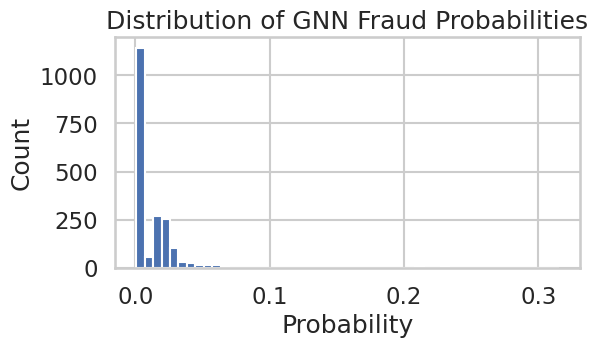

ROC-AUC: 1.0
PR-AUC: 1.0
Confusion matrix at thresh=0.5:
 [[1958    0]
 [  42    0]]
Classification report at thresh=0.5:
               precision    recall  f1-score   support

           0     0.9790    1.0000    0.9894      1958
           1     0.0000    0.0000    0.0000        42

    accuracy                         0.9790      2000
   macro avg     0.4895    0.5000    0.4947      2000
weighted avg     0.9584    0.9790    0.9686      2000


Top rows by GNN prob:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Name,Document_Type,Document_Number,Fraud_Risk_Score,GNN_Fraud_Probability,Address_clean
1644,Aayush Bahri,,,0.7,0.315311,hno 294 choudhary circle malegaon957754
1897,Oorja Kari,,,0.7,0.305561,hno 002 sinha ganj bathinda 405480
338,Renee Bawa,,,0.7,0.303733,062 acharya street bhiwani584496
380,Anahita Bajwa,Aadhaar,1696 4805 6893,0.7,0.299135,87 ram path bongaigaon 445142
526,Divij Chaudhuri,,,0.7,0.288319,99 ghose path panchkula817149
163,Taimur Rajagopal,,,0.7,0.278217,80726 batra path pimprichinchwad726182
714,Ishaan Divan,,,0.7,0.262446,hno 57 dhingra chowk morena505881
329,Ivan Sibal,,,0.7,0.250748,0638 bhandari chowk kurnool232617
825,Ehsaan Ramakrishnan,,,0.7,0.247203,18747 bose road ludhiana009957
1169,Kartik Dugal,,,0.7,0.237672,1841 chawla street malda886033



Top rows by rule-based Fraud_Risk_Score:


,Name,Document_Type,Document_Number,Fraud_Risk_Score,GNN_Fraud_Probability,Address_clean
6,Eva Barad,,,0.7,0.214141,hno 06 bhargava marg bathinda511991
308,Hunar Dayal,Aadhaar,1294 6716 3980,0.7,0.203263,hno 97 barad ganj nadiad239635
1016,Purab Tiwari,Aadhaar,1800 7218 4465,0.7,0.213528,3666 cheema circle tinsukia 038147
56,Aaina Sane,Aadhaar,2012 2592 6215,0.7,0.219521,48 varughese street karawal nagar 818917
1644,Aayush Bahri,,,0.7,0.315311,hno 294 choudhary circle malegaon957754
666,Riya Rajan,Aadhaar,7678 1784 1621,0.7,0.232484,hno 28 krishnamurthy path barasat534619
338,Renee Bawa,,,0.7,0.303733,062 acharya street bhiwani584496
346,Divit Kuruvilla,Aadhaar,7940 4189 8607,0.7,0.227437,88354 soman circle madurai564331
1264,Sumer Chand,Aadhaar,6826 2739 6800,0.7,0.210771,40 batra road rajpur sonarpur271504
560,Abram Hegde,Aadhaar,9678 5002 8785,0.7,0.237446,hno 46 bhasin path gwalior 361323


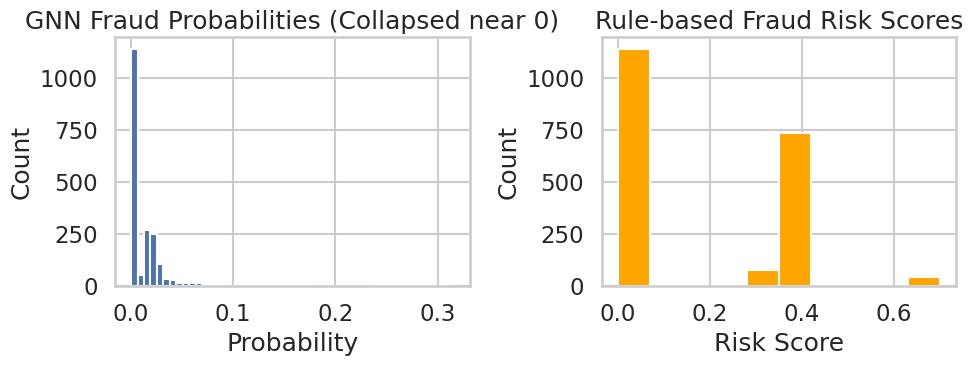

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report, confusion_matrix

# 1) Basic counts & label balance
print("Total rows:", len(df))
if 'label' in df.columns:
    print("Label distribution:\n", df['label'].value_counts(dropna=False))
else:
    print("No 'label' column found. Create ground-truth labels or pseudo-labels before trusting metrics.")

# 2) Inspect GNN probability distribution
probs = df['GNN_Fraud_Probability'].astype(float).values
print("GNN probability stats -> min, mean, median, max:", probs.min(), probs.mean(), np.median(probs), probs.max())
print("Unique probability values count:", np.unique(np.round(probs, 6)).size)

# Plot histogram
plt.figure(figsize=(6,3))
plt.hist(probs, bins=50)
plt.title("Distribution of GNN Fraud Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

# 3) If labels present: quick ROC-AUC & PR-AUC & confusion at threshold
if 'label' in df.columns and len(df['label'].unique())>1:
    y_true = df['label'].astype(int).values
    try:
        roc = roc_auc_score(y_true, probs)
        print("ROC-AUC:", roc)
    except Exception as e:
        print("ROC error:", e)
    # PR-AUC
    precision, recall, th = precision_recall_curve(y_true, probs)
    pr_auc = auc(recall, precision)
    print("PR-AUC:", pr_auc)

    # choose threshold: e.g., 0.5 or use percentile / Youden
    thresh = 0.5
    preds = (probs >= thresh).astype(int)
    print("Confusion matrix at thresh=0.5:\n", confusion_matrix(y_true, preds))
    print("Classification report at thresh=0.5:\n", classification_report(y_true, preds, digits=4))
else:
    print("Skipping ROC/PR (need both classes present in 'label').")

# 4) Show top-k suspicious rows by model prob and by rule score side-by-side
topk = 15
print("\nTop rows by GNN prob:")
display(df.sort_values('GNN_Fraud_Probability', ascending=False).head(topk)[['Name','Document_Type','Document_Number','Fraud_Risk_Score','GNN_Fraud_Probability','Address_clean']])

print("\nTop rows by rule-based Fraud_Risk_Score:")
display(df.sort_values('Fraud_Risk_Score', ascending=False).head(topk)[['Name','Document_Type','Document_Number','Fraud_Risk_Score','GNN_Fraud_Probability','Address_clean']])

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# Left: GNN probabilities
plt.subplot(1,2,1)
plt.hist(df['GNN_Fraud_Probability'], bins=50)
plt.title('GNN Fraud Probabilities (Collapsed near 0)')
plt.xlabel('Probability')
plt.ylabel('Count')

# Right: Rule-based fraud scores
plt.subplot(1,2,2)
plt.hist(df['Fraud_Risk_Score'], bins=10, color='orange')
plt.title('Rule-based Fraud Risk Scores')
plt.xlabel('Risk Score')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [ ]:
# flag top 1% by GNN probability
pct = 0.01
k = max(1, int(len(df) * pct))
flagged = df.sort_values('GNN_Fraud_Probability', ascending=False).head(k)


In [ ]:
from sklearn.metrics import f1_score
# using validation preds/probs arrays val_true, val_probs (you should compute during training)
# find best threshold by F1
best_t, best_f1 = 0.0, 0.0
for t in np.linspace(0,1,101):
    f1 = f1_score(val_true, (val_probs >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_t = f1, t
print("Best val threshold by F1:", best_t, "F1:", best_f1)


NameError: name 'val_true' is not defined